# Triangulate Each Cluster

In [1]:
import gc
import os
import pickle
import sys
import time
import uuid
from typing import Final, Optional

import cv2 as OpenCV
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.cluster.vq import kmeans, vq
from scipy.spatial import Delaunay
import cv2
from scipy.optimize import least_squares

import subprocess


In [2]:
class Image:
    def __init__(self, img_id, rgb_image, gray_image, mask, keypoints, descriptors, path):
        self.img_id: int = int(img_id)
        self.unique_id: uuid = uuid.uuid4()
        self.rgb_image: Image = rgb_image
        self.gray_image: Image = gray_image
        self.mask: Image = mask
        self.keypoints: list[OpenCV.KeyPoint] = keypoints
        self.descriptors: np.ndarray = descriptors
        self.path: str = path

    @property
    def length(self):
        return f"{len(self.keypoints)}" if len(self.keypoints) == len(self.descriptors) else f"{len(self.keypoints)}, {len(self.descriptors)}"
    
    def draw_sift_features(self):
        image_with_sift = OpenCV.drawKeypoints(self.rgb_image, self.keypoints, None, flags=OpenCV.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(image_with_sift)
        plt.title("Image with SIFT Features")
        plt.axis('off')
        plt.show()

    def display_rgb_image(self, title: Optional[str] = None):
        image = self.rgb_image
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axis('off')
        plt.show()

    def display_gray_image(self, title: Optional[str] = None):
        image = self.gray_image
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axes('off')
        plt.show()
        
    def display_mask_image(self, title: Optional[str] = None):
        image = self.mask
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axes('off')
        plt.show()
        
    def display_dialated_image(self, title: Optional[str] = None):
        print(self.mask.shape)
        print(self.rgb_image.shape)
        image = OpenCV.bitwise_and(self.rgb_image, self.rgb_image, mask=self.mask)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axis('off')
        plt.show()
        
    def __repr__(self):
        return f"Image({self.img_id})"
    
    def __str__(self):
        return self.__repr__()
    
    def __eq__(self, other):
        return self.unique_id == other.unique_id
    
    def __hash__(self):
        return hash(self.img_id)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        state['keypoints'] = [tuple(k.pt) + (k.size, k.angle, k.response, k.octave, k.class_id) for k in self.keypoints]
        return state
    
    def __setstate__(self, state):
        state['keypoints'] = [OpenCV.KeyPoint(x, y, size, angle, response, octave, class_id) for x, y, size, angle, response, octave, class_id in state['keypoints']]
        self.__dict__ = state

class FeatureMatches:
    def __init__(self, image_one: Image, image_two: Image, matches: list[OpenCV.DMatch]):
        self.image_one: Image = image_one
        self.image_two: Image = image_two
        self.matches: list[OpenCV.DMatch] = matches

    def draw_matches(self, output_filename: str) -> None:
        combined_image = OpenCV.hconcat([
            self.image_one.rgb_image,
            self.image_two.rgb_image
        ])
        for match in self.matches:
            x1, y1 = self.image_one.keypoints[match.queryIdx].pt
            x2, y2 = self.image_two.keypoints[match.trainIdx].pt
            # Draw a line connecting the matched keypoints
            OpenCV.line(
                combined_image, 
                (int(x1), int(y1)), 
                (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
                (0, 255, 0), 
                1
            )
        OpenCV.imwrite(output_filename, combined_image)
        
    def animate_matches(self, output_filename: str) -> None:
        # for match in self.matches:
        #     combined_image = OpenCV.hconcat([
        #         self.image_one.rgb_image,
        #         self.image_two.rgb_image
        #     ])
        #     x1, y1 = self.image_one.keypoints[match.queryIdx].pt
        #     x2, y2 = self.image_two.keypoints[match.trainIdx].pt
        #     # Write match.queryIdx at the top left corner
        #     OpenCV.putText(
        #         combined_image,
        #         f"{match.queryIdx}",
        #         (50, 150),  # position: 10 pixels from left, 20 pixels from top
        #         OpenCV.FONT_HERSHEY_SIMPLEX,  # font
        #         5,  # font scale
        #         (0, 255, 0),  # font color (green)
        #         5,  # thickness
        #         OpenCV.LINE_AA  # line type
        #     )
        #     # Write match.trainIdx at the top right corner
        #     image_two_width = self.image_one.rgb_image.shape[1]
        #     OpenCV.putText(
        #         combined_image,
        #         f"{match.trainIdx}",
        #         (image_two_width + 50, 150),  # position: 10 pixels from right, 20 pixels from top
        #         OpenCV.FONT_HERSHEY_SIMPLEX,  # font
        #         5,  # font scale
        #         (0, 255, 0),  # font color (green)
        #         5,  # thickness
        #         OpenCV.LINE_AA  # line type
        #     )
        #     # Draw a line connecting the matched keypoints
        #     OpenCV.line(
        #         combined_image, 
        #         (int(x1), int(y1)), 
        #         (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
        #         (0, 255, 0), 
        #         1
        #     )
        #     OpenCV.imwrite(output_filename + f"/{match.queryIdx}_{match.trainIdx}.jpg", combined_image)
        framerate = 120

        # Get a list of image files in the directory
        image_files = [f for f in os.listdir(output_filename) if f.endswith(".jpg")]
        image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

        # Create a temporary file with a list of input images
        with open("input_files.txt", "w") as f:
            for image_file in image_files:
                f.write(f"file '{os.path.join(output_filename, image_file)}'\n")

        # Run FFmpeg command to create a video
        command = f'ffmpeg -y -f concat -safe 0 -i "input_files.txt" -framerate {framerate} -c:v libx264 -pix_fmt yuv420p "{output_filename}/output.mp4"'
        subprocess.run(command, shell=True, check=True)

        # Remove temporary file
        os.remove("input_files.txt")

    def __repr__(self):
        return f"FeatureMatches({self.image_one}, {self.image_two} ---> {len(self.matches)})"

    def __getstate__(self):
        state = self.__dict__.copy()
        state['matches'] = [
            {'queryIdx': m.queryIdx, 'trainIdx': m.trainIdx, 'distance': m.distance} for m in self.matches
        ]
        return state
    
    def __setstate__(self, state):
        state['matches'] = [
            OpenCV.DMatch(match['queryIdx'], match['trainIdx'], match['distance']) for match in state['matches']
        ]
        self.__dict__ = state
    
class Images:
    def __init__(self, images: list[Image], image_set_name: str):
        self.id = uuid.uuid4()
        self.images: list[Image] = images
        self.image_set_name: str = image_set_name
        self.feature_matches: list[FeatureMatches] = []
        self.similar_images: dict[list[Image]] = {}
        self.num_clusters: int = 50

    def save_feature_matches(self):
        for match in self.feature_matches:
            match.draw_matches(f"data/{self.image_set_name}/output/feature-match/{match.image_one.img_id}_{match.image_two.img_id}.jpg")

    def __len__(self):
        return len(self.images)
    
    def display_similar_images(self, key):
        print(f"cluster {key}")
        print("-----------------------------------------------------")
        for value in self.similar_images[key]:
            print(value)
            rgb_image = OpenCV.cvtColor(OpenCV.imread(value.path), OpenCV.COLOR_BGR2RGB)
            plt.imshow(rgb_image)
            plt.title(value.path)
            plt.axis('off')
            plt.show()

    def save_similar_images(self):
        for cluster in self.similar_images.keys():
            if not os.path.exists(f"data/{self.image_set_name}/output/image-match/{cluster}"):
                os.makedirs(f"data/{self.image_set_name}/output/image-match/{cluster}")
            for value in self.similar_images[cluster]:
                OpenCV.imwrite(f"data/{self.image_set_name}/output/image-match/{cluster}/{value.img_id}.jpg", value.rgb_image)

    def __getitem__(self, key: int) -> Image:
        for image in self.images:
            if image.img_id == key:
                return image
        raise KeyError(f'Image with img_id {key} not found.')

In [3]:
def feature_matching(
        img_one_descriptors: np.ndarray, 
        img_two_descriptors: np.ndarray,
    ) -> list[OpenCV.DMatch]:
    matcher = OpenCV.BFMatcher(crossCheck=True)
    return matcher.match(img_one_descriptors, img_two_descriptors)


def apply_ransac(matches, keypoints1, keypoints2, threshold = 3.0):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    _, mask = OpenCV.findHomography(src_pts, dst_pts, OpenCV.RANSAC, threshold)
    matches_mask = mask.ravel().tolist()
    return [m for m, keep in zip(matches, matches_mask) if keep]


def data_feature_matching(images: Images) -> None:
    import itertools
    for _, values in images.similar_images.items():
        print(images.similar_images.items())
        for image, matched_image in itertools.combinations(values, 2):
            feature_matching_output = feature_matching(image.descriptors, matched_image.descriptors)
            ransac_output = apply_ransac(feature_matching_output, image.keypoints, matched_image.keypoints, threshold=150)
            images.feature_matches.append(FeatureMatches(image, matched_image, ransac_output))

In [4]:
# import numpy as np
# import cv2 as OpenCV
# from typing import List, Tuple

# def check_coherent_rotation(R: np.ndarray) -> bool:
#     epsilon = 1e-6
#     return np.abs(np.linalg.det(R) - 1.0) <= epsilon


# def find_camera_matrices(K: np.ndarray, keypoints_one: np.ndarray, keypoints_two: np.ndarray, matches: List) -> Tuple[np.ndarray, np.ndarray]:
#     # Get Fundamental Matrix
#     F, _ = OpenCV.findFundamentalMat(keypoints_one, keypoints_two, method=OpenCV.FM_RANSAC, ransacReprojThreshold=3)

#     # Compute Essential matrix
#     E = K.T @ F @ K

#     # Decompose Essential matrix using SVD
#     _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K)

#     # Check if the resulting rotation is coherent
#     if not check_coherent_rotation(R):
#         print("Resulting rotation is not coherent")
#         return None, None
#     print("Resulting rotation is coherent")

#     return np.hstack((R, t))


# def generate_point_cloud_book(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
#     point_cloud = []

#     for feature_match in images.feature_matches:
#         image_one = feature_match.image_one
#         image_two = feature_match.image_two

#         # Extract matched keypoints
#         keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
#         keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])

#         # Find Camera Matrices
#         P1 = find_camera_matrices(K_matrix, keypoints_one, keypoints_two, feature_match.matches)
#         if P1 is None:
#             continue

#         # Create projection matrices
#         P0 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
#         P1 = K_matrix @ P1

#         # Triangulate points
#         points_4D = OpenCV.triangulatePoints(P0, P1, keypoints_one.T, keypoints_two.T)
#         points_3D = (points_4D / points_4D[3])[:3]

#         point_cloud.append(points_3D)

#     return np.hstack(point_cloud).T

In [5]:
def generate_point_cloud(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
    def remove_outliers(points_3D: np.ndarray, threshold: float = 100.0) -> np.ndarray:
        # Calculate the mean and standard deviation of the 3D points
        mean = points_3D.mean(axis=0)
        std_dev = points_3D.std(axis=0)

        # Remove points that are farther than the threshold * standard deviation from the mean
        inliers = np.all(np.abs(points_3D - mean) < threshold * std_dev, axis=1)

        return points_3D[inliers]

    point_cloud = []
    print("Feature Matches No. of Pairs: ", len(images.feature_matches))
    for i, feature_match in enumerate(images.feature_matches):
        image_one = feature_match.image_one
        image_two = feature_match.image_two

        # Extract matched keypoints
        keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
        keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])

        # Estimate the essential matrix
        E, mask = OpenCV.findEssentialMat(keypoints_one, keypoints_two, K_matrix, method=OpenCV.RANSAC, prob=0.999, threshold=1.0)
        _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K_matrix)

        print(f"R of Pair {i}: ", R)
        print(f"t of Pair {i}: ", t)
        print(f"Essential Matrix of Pair {i}: ", E)
        print("Keypoint_1 Shape: ", keypoints_one.shape)
        print("Keypoint_2 Shape: ", keypoints_two.shape)
        print("\n")
        # Create projection matrices
        P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1)))) #P1 Shape: (3, 4)
        P2 = K_matrix @ np.hstack((R, t)) #P2 Shape: (3, 4)

        # Triangulate points
        points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
        points_3D = (points_4D / points_4D[3])[:3].T

        # Remove outliers in the triangulated points
        points_3D = remove_outliers(points_3D)

        point_cloud.append(points_3D)

    # Merge all point clouds into one
    point_cloud = np.vstack(point_cloud)

    return point_cloud

In [6]:
def generate_point_cloud_book(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
    point_cloud = []

    for feature_match in images.feature_matches:
        image_one = feature_match.image_one
        image_two = feature_match.image_two

        # Extract matched keypoints
        keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
        keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])
        # for match in feature_match.matches:
        #     keypoints_one = np.array([image_one.keypoints[match.queryIdx].pt])
        #     keypoints_two = np.array([image_two.keypoints[match.trainIdx].pt])


        # Normalize keypoints using the K matrix
        # keypoints_one_normalized = np.linalg.inv(K_matrix) @ np.vstack((keypoints_one.T, np.ones(keypoints_one.shape[0])))
        # keypoints_two_normalized = np.linalg.inv(K_matrix) @ np.vstack((keypoints_two.T, np.ones(keypoints_two.shape[0])))

        # Estimate the Fundamental matrix using the 8-point algorithm
        # F, _ = OpenCV.findFundamentalMat(keypoints_one_normalized[:2].T, keypoints_two_normalized[:2].T, method=OpenCV.FM_8POINT)
        print("Keypoint_1 Shape: ", keypoints_one.shape)
        print("Keypoint_2 Shape: ", keypoints_two.shape)
        print(keypoints_one)
        print(keypoints_two)
        F, _ = OpenCV.findFundamentalMat(keypoints_one, keypoints_two, method=OpenCV.FM_RANSAC, ransacReprojThreshold=0.1, confidence=0.99)

        # Estimate the Essential matrix
        E = K_matrix.T @ F @ K_matrix

        # Decompose the Essential matrix to get R|t using SVD
        _, R, t, _ = OpenCV.recoverPose(F, keypoints_one, keypoints_two, K_matrix)

        # Create projection matrices
        P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = K_matrix @ np.hstack((R, t))

        # Triangulate points
        points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
        points_3D = (points_4D / points_4D[3])[:3]

        point_cloud.append(points_3D)

    return np.hstack(point_cloud).T

In [7]:
def dump_images_bak(images_file_path: str, images: Images) -> None:
    """ Dump images to a file """
    with open(images_file_path, "wb") as file:
        pickle.dump(images, file)

def load_images_bak(images_file_path: str) -> Images:
    """ Load images from a file """
    with open(images_file_path, "rb") as file:
        images = pickle.load(file)
    return images

In [8]:
def compute_keypoints_descriptors(images: list[Image]) -> None:
    sift = OpenCV.SIFT_create(contrastThreshold=0.01)
    for img in images.images:
        keypoints: list[OpenCV.KeyPoint]
        descriptors: np.ndarray
        dialated_image = OpenCV.bitwise_and(img.gray_image, img.gray_image, mask=img.mask)
        keypoints, descriptors = sift.detectAndCompute(dialated_image, None)
        img.keypoints = keypoints
        img.descriptors = descriptors

In [9]:
def prepare_images(create_mask = False, **kwargs) -> Images:
    image_set_name = kwargs['image_set_name']
    folder_path = f"data/{image_set_name}"
    images: Images = Images([], folder_path.split("/")[-1])
    files: list[str] = list(filter(lambda file: ".jpg" in file, os.listdir(folder_path + "/images")))
    if create_mask:
        from rembg import remove
        for file in files:
            image_path = f"{folder_path}/images/{file}"
            rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
            gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
            mask = remove(rgb_image)
            mask = OpenCV.cvtColor(mask, OpenCV.COLOR_RGB2GRAY)
            mask[mask > 0] = 255
            OpenCV.imwrite(f"{folder_path}/masks/{file}", mask)
            kernel = np.ones((5, 5), np.uint8)
            dilated_mask = OpenCV.dilate(mask, kernel, iterations=20)
            images.images.append(Image(file.split(".")[0], rgb_image, gray_image, dilated_mask, [], [], image_path))
    else:
        for file in files:
            image_path = f"{folder_path}/images/{file}"
            mask_path = f"{folder_path}/masks/{file}"
            rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
            gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
            mask = OpenCV.imread(mask_path, OpenCV.IMREAD_GRAYSCALE)
            kernel = np.ones((5, 5), np.uint8)
            dilated_mask = OpenCV.dilate(mask, kernel, iterations=20)
            images.images.append(Image(file.split(".")[0], rgb_image, gray_image, dilated_mask, [], [], image_path))
    return images

In [10]:
images: Optional[Images] = prepare_images(create_mask=False, image_set_name="cottage")

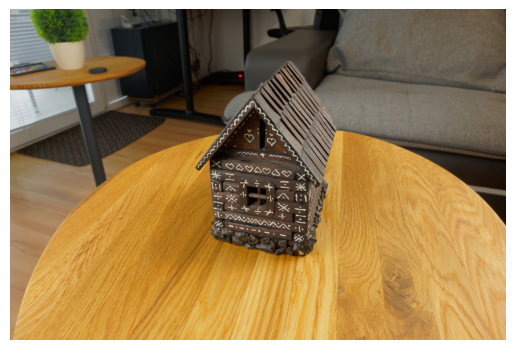

In [11]:
images[10].display_rgb_image()

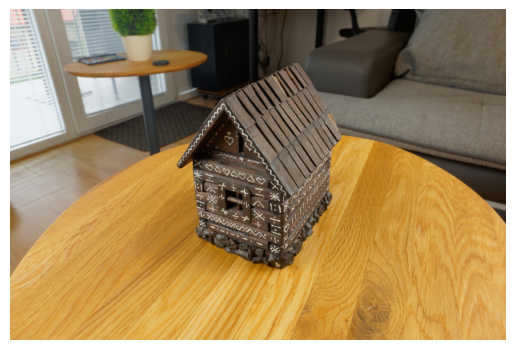

In [12]:
images[11].display_rgb_image()

In [13]:
compute_keypoints_descriptors(images)

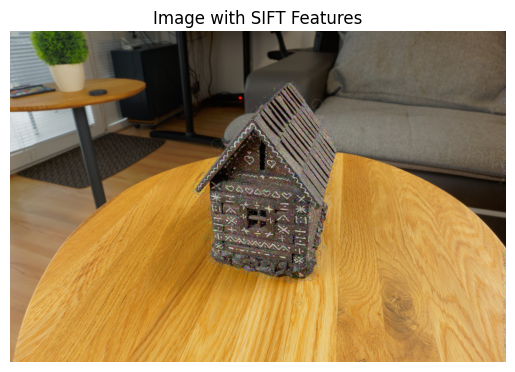

In [14]:
images[10].draw_sift_features()

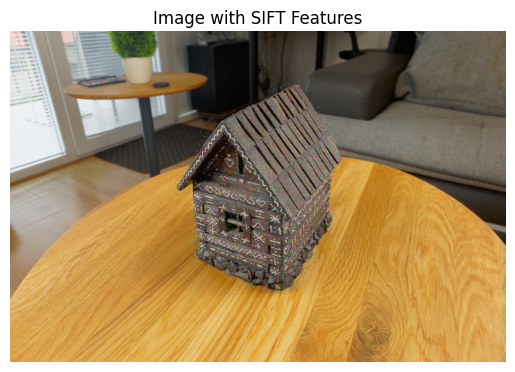

In [15]:
images[11].draw_sift_features()

In [16]:
images.similar_images = {
    "0": [images[1], images[2]],
    "1": [images[2], images[3]],
    "2": [images[3], images[4]],
    "3": [images[4], images[5]],
    "4": [images[5], images[6]],
    "5": [images[6], images[7]],
    # "1": [images[11], images[12], images[13], images[14], images[15], images[16], images[17], images[18], images[19], images[20], images[21], 
    #     images[22], images[23], images[24], images[25], images[26], images[27]]
}

In [17]:
print(images.similar_images.items())

dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3)]), ('2', [Image(3), Image(4)]), ('3', [Image(4), Image(5)]), ('4', [Image(5), Image(6)]), ('5', [Image(6), Image(7)])])


In [18]:
data_feature_matching(images)

dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3)]), ('2', [Image(3), Image(4)]), ('3', [Image(4), Image(5)]), ('4', [Image(5), Image(6)]), ('5', [Image(6), Image(7)])])
dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3)]), ('2', [Image(3), Image(4)]), ('3', [Image(4), Image(5)]), ('4', [Image(5), Image(6)]), ('5', [Image(6), Image(7)])])
dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3)]), ('2', [Image(3), Image(4)]), ('3', [Image(4), Image(5)]), ('4', [Image(5), Image(6)]), ('5', [Image(6), Image(7)])])
dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3)]), ('2', [Image(3), Image(4)]), ('3', [Image(4), Image(5)]), ('4', [Image(5), Image(6)]), ('5', [Image(6), Image(7)])])
dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3)]), ('2', [Image(3), Image(4)]), ('3', [Image(4), Image(5)]), ('4', [Image(5), Image(6)]), ('5', [Image(6), Image(7)])])
dict_items([('0', [Image(1), Image(2)]), ('1', [Image(2), Image(3

In [19]:
images.feature_matches[0].draw_matches("data/cottage/output/triangulate/10_11.jpg")

In [20]:
# images.feature_matches[0].animate_matches("data/fountain/output/triangulate/2_3")

In [21]:
def compute_k_matrix(img_path: str, **kwargs) -> np.ndarray:
    import numpy as np
    # distortion_coefficients = exif['EXIF MakerNote'].values[0]
    # Calculate the scaling factor for the K-matrix
    focal_length = 4044.943820224719
    principal_point_x = 3000
    principal_point_y = 2000
    scaling_factor = 1.0
    return np.array(
        [
            [float(focal_length), 0, principal_point_x],
            [0, float(focal_length), principal_point_y],
            [0, 0, scaling_factor],
        ]
    )
with open(f"data/cottage/bak/K_matrix.pickle", 'wb') as f:
    pickle.dump(compute_k_matrix("data/cottage/images"), f)

In [22]:
len(images.feature_matches[0].matches)

31908

In [23]:
import pickle
with open("data/cottage/bak/K_matrix.pickle", 'rb') as f:
        K_matrix = pickle.load(f)

In [24]:
print(K_matrix)

[[4.04494382e+03 0.00000000e+00 3.00000000e+03]
 [0.00000000e+00 4.04494382e+03 2.00000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [25]:
for row in K_matrix:
    for num in row:
        print(num, end=" ")

4044.943820224719 0.0 3000.0 0.0 4044.943820224719 2000.0 0.0 0.0 1.0 

# Clustering from: 10 and 11

In [26]:
data_10_11_points_cloud: np.ndarray = generate_point_cloud(images, K_matrix)

Feature Matches No. of Pairs:  6
R of Pair 0:  [[ 9.84129688e-01 -8.78154928e-02  1.54198560e-01]
 [ 8.88446180e-02  9.96045474e-01  2.17887393e-04]
 [-1.53607912e-01  1.34852827e-02  9.88039856e-01]]
t of Pair 0:  [[-0.99417642]
 [ 0.06677225]
 [-0.08458559]]
Essential Matrix of Pair 0:  [[ 0.00193873 -0.06021123 -0.04666345]
 [ 0.16684648 -0.01473234 -0.68535826]
 [ 0.10892257  0.69606268  0.00743368]]
Keypoint_1 Shape:  (31908, 2)
Keypoint_2 Shape:  (31908, 2)


R of Pair 1:  [[ 0.96541115 -0.11693633  0.23303905]
 [ 0.11929996  0.99285029  0.00397685]
 [-0.23183793  0.02396225  0.97245925]]
t of Pair 1:  [[-0.95888446]
 [-0.11474997]
 [ 0.25956317]]
Essential Matrix of Pair 1:  [[ 0.00308474  0.18417094  0.07963572]
 [-0.01999655  0.00521515 -0.70213187]
 [ 0.00255547  0.68267423 -0.01621246]]
Keypoint_1 Shape:  (21885, 2)
Keypoint_2 Shape:  (21885, 2)


R of Pair 2:  [[ 9.80924980e-01 -9.28223840e-02  1.70792823e-01]
 [ 9.42117155e-02  9.95552184e-01 -2.98493216e-05]
 [-1.70030397

In [27]:
book_10_11_points_cloud: np.ndarray = generate_point_cloud_book(images, K_matrix)

Keypoint_1 Shape:  (31908, 2)
Keypoint_2 Shape:  (31908, 2)
[[2001.85644531 2023.17468262]
 [2009.69067383 1399.0369873 ]
 [2020.76831055 1643.95141602]
 ...
 [4178.95751953 2046.55578613]
 [4178.97363281 2061.45385742]
 [4179.88476562 2030.32763672]]
[[1850.86572266 2011.18408203]
 [1922.09423828 1518.90795898]
 [1918.56286621 1656.33984375]
 ...
 [4085.04272461 2219.91455078]
 [4083.50927734 2236.54003906]
 [4088.48486328 2202.7265625 ]]
Keypoint_1 Shape:  (21885, 2)
Keypoint_2 Shape:  (21885, 2)
[[1862.04541016 1927.26513672]
 [1891.44750977 2157.38964844]
 [1905.20568848 2043.71350098]
 ...
 [4097.390625   2190.09130859]
 [4097.9140625  1739.5300293 ]
 [4126.37988281 1925.31262207]]
[[1961.98803711 1815.15429688]
 [1998.78222656 1941.97119141]
 [2036.71936035 1766.61950684]
 ...
 [3982.7734375  2217.66845703]
 [4058.28393555 1759.39172363]
 [4068.61938477 1921.59375   ]]
Keypoint_1 Shape:  (23021, 2)
Keypoint_2 Shape:  (23021, 2)
[[1985.25390625 1935.43518066]
 [2000.23083496 1875.

In [28]:
import hdbscan
hdbscan_model = hdbscan.HDBSCAN().fit(data_10_11_points_cloud)
labels = hdbscan_model.labels_
core_indices = np.where(labels != -1)[0]
data_core_points_10_11_HDBSCAN = data_10_11_points_cloud[core_indices, :]

In [29]:
import hdbscan
hdbscan_model = hdbscan.HDBSCAN().fit(book_10_11_points_cloud)
labels = hdbscan_model.labels_
core_indices = np.where(labels != -1)[0]
book_core_points_10_11_HDBSCAN = book_10_11_points_cloud[core_indices, :]

In [30]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=10).fit(one_11_points_cloud)
# labels = dbscan.labels_
# core_indices = np.where(labels != -1)[0]
# core_points_1_11_DBSCAN = one_11_points_cloud[core_indices, :]

In [31]:
print(data_core_points_10_11_HDBSCAN.shape)
print(book_core_points_10_11_HDBSCAN.shape)

(74528, 3)
(67748, 3)


In [32]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data_core_points_10_11_HDBSCAN[:,:3])
o3d.io.write_point_cloud(
    "data/cottage/output/triangulate/data_core_points_10_11_HDBSCAN.ply", pcd
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


True

In [33]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(book_core_points_10_11_HDBSCAN[:,:3])
o3d.io.write_point_cloud(
    "data/cottage/output/triangulate/book_core_points_10_11_HDBSCAN.ply", pcd
)

True

# Visualizing Points Cloud

In [34]:
import open3d as o3d
file_path = (
    "data/cottage/output/triangulate/data_core_points_10_11_HDBSCAN.ply"
)
point_cloud = o3d.io.read_point_cloud(file_path)
o3d.visualization.draw_geometries([point_cloud])